### Importing Necessary Libraries

In [1]:
# ! pip install transformers==3.2.0 --user
# ! pip install tensorflow==2.2 --user

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import string as s
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics  import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import tensorflow as tf
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [3]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

### Data Pre-Processing

In [4]:
# Loading category list
category_list_df = pd.read_csv("categories.csv")
category_list_df

id                    category
0   1                      Layoff
1   2    Mergers and Acquisitions
2   3                 Mass Hiring
3   4          Executive Movement
4   5  Centre Setup and Expansion
5   6                       Deals
6   7                Partnerships

In [5]:
# Loading category mapping list
category_mapping_df = pd.read_excel("category_mapping.xlsx")
category_mapping_df.head()

news_id  category_id
0  5cb377684f646938b14a96f1_google            4
1  5cb426d44f646938b10bf6b6_google            4
2  5cb429984f646938b110f937_google            2
3  5cb426b34f646938b10bbeca_google            5
4  5cb426f74f646938b10c3857_google            7

In [6]:
# Loading news data
news_details_df = pd.read_excel("news_details.xlsx")
news_details_df = news_details_df.drop_duplicates(keep='first')
news_details_df.head()

news_id  \
0  5cb377684f646938b14a96f1_google   
1  5cb426d44f646938b10bf6b6_google   
2  5cb429984f646938b110f937_google   
3  5cb426b34f646938b10bbeca_google   
4  5cb426f74f646938b10c3857_google   

                                             snippet  \
0  New Delhi: Bank of Baroda, which has become th...   
1  He said his plans would be discussed with the ...   
2  ZF Friedrichshafen AG has announced that it ha...   
3  Zhejiang Geely Holding (ZGH) has begun constru...   
4  KFH has partnered with IDEMIA to launch Kuwait...   

                                               title  \
0  Bank of Baroda to hire consultancy firm to eva...   
1  Foxconn chairman Gou says he aims to step down...   
2   ZF Finalizes USD 7 Billion Deal to Acquire WABCO   
3      Geely Begins Work On New Lotus Plant In China   
4  KFH partners with IDEMIA's to launch metal pay...   

                                    news_description  
0                                                NaN  
1  TAIPEI (Reuters) - The chairman of Taiwan's Fo...  
2  Share 0 Share 0\n\nZF Friedrichshafen AG has a...  
3  Zhejiang Geely Holding (ZGH) has begun constru...  
4                                                NaN

In [7]:
# Mapping news_id with category name
category_df = pd.merge(category_mapping_df, category_list_df, left_on='category_id', right_on="id").drop('id', axis=1)
category_df = category_df.drop_duplicates(keep='first')
category_df.head()

news_id  category_id            category
0  5cb377684f646938b14a96f1_google            4  Executive Movement
1  5cb426d44f646938b10bf6b6_google            4  Executive Movement
2  5cb427e74f646938b10de598_google            4  Executive Movement
3  5cb428694f646938b10ed222_google            4  Executive Movement
4  5cb4286c4f646938b10ed659_google            4  Executive Movement

In [8]:
# Mapping news_id with category_id
final_df = news_details_df.merge(category_df, on='news_id')
final_df.head()

news_id  \
0  5cb377684f646938b14a96f1_google   
1  5cb426d44f646938b10bf6b6_google   
2  5cb429984f646938b110f937_google   
3  5cb426b34f646938b10bbeca_google   
4  5cb426f74f646938b10c3857_google   

                                             snippet  \
0  New Delhi: Bank of Baroda, which has become th...   
1  He said his plans would be discussed with the ...   
2  ZF Friedrichshafen AG has announced that it ha...   
3  Zhejiang Geely Holding (ZGH) has begun constru...   
4  KFH has partnered with IDEMIA to launch Kuwait...   

                                               title  \
0  Bank of Baroda to hire consultancy firm to eva...   
1  Foxconn chairman Gou says he aims to step down...   
2   ZF Finalizes USD 7 Billion Deal to Acquire WABCO   
3      Geely Begins Work On New Lotus Plant In China   
4  KFH partners with IDEMIA's to launch metal pay...   

                                    news_description  category_id  \
0                                                NaN            4   
1  TAIPEI (Reuters) - The chairman of Taiwan's Fo...            4   
2  Share 0 Share 0\n\nZF Friedrichshafen AG has a...            2   
3  Zhejiang Geely Holding (ZGH) has begun constru...            5   
4                                                NaN            7   

                     category  
0          Executive Movement  
1          Executive Movement  
2    Mergers and Acquisitions  
3  Centre Setup and Expansion  
4                Partnerships

In [9]:
# Printing Sample Snippet
final_df.iloc[3][1]

'Zhejiang Geely Holding (ZGH) has begun construction on a new 9 billion ... While the new plant is responsible for assembling Lotus vehicles, Geely did not\\xa0...'

In [10]:
# Printing Sample Title
final_df.iloc[3][2]

'Geely Begins Work On New Lotus Plant In China'

In [11]:
# Printing Sample News Description
final_df.iloc[3][3]

'Zhejiang Geely Holding (ZGH) has begun construction on a new 9 billion Yuan production plant in Wuhan, Hubei.\\n\\nWhen the new plant goes online in 2021, it will be assembling a range of high-end vehicles, including models from Lotus. Lotus vehicles are currently built in Norfolk, England and the Wuhan plant will be the company\\u2019s first production plant outside of the UK.\\n\\nAccording to Autonews, the new Wuhan plant is capable of assembling 150,000 conventional and electrified vehicles annually.\\n\\nWhile the new plant is responsible for assembling Lotus vehicles, Geely did not mention what other vehicles will the new Wuhan plant assemble.'

In [12]:
# Checking for missing snippets/titles/descriptions
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2721 entries, 0 to 2720
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   news_id           2721 non-null   object
 1   snippet           2716 non-null   object
 2   title             2721 non-null   object
 3   news_description  2535 non-null   object
 4   category_id       2721 non-null   int64 
 5   category          2721 non-null   object
dtypes: int64(1), object(5)
memory usage: 148.8+ KB


In [13]:
# Replacing NAs with empty string
final_df = final_df.fillna('')
final_df.head()

news_id  \
0  5cb377684f646938b14a96f1_google   
1  5cb426d44f646938b10bf6b6_google   
2  5cb429984f646938b110f937_google   
3  5cb426b34f646938b10bbeca_google   
4  5cb426f74f646938b10c3857_google   

                                             snippet  \
0  New Delhi: Bank of Baroda, which has become th...   
1  He said his plans would be discussed with the ...   
2  ZF Friedrichshafen AG has announced that it ha...   
3  Zhejiang Geely Holding (ZGH) has begun constru...   
4  KFH has partnered with IDEMIA to launch Kuwait...   

                                               title  \
0  Bank of Baroda to hire consultancy firm to eva...   
1  Foxconn chairman Gou says he aims to step down...   
2   ZF Finalizes USD 7 Billion Deal to Acquire WABCO   
3      Geely Begins Work On New Lotus Plant In China   
4  KFH partners with IDEMIA's to launch metal pay...   

                                    news_description  category_id  \
0                                                               4   
1  TAIPEI (Reuters) - The chairman of Taiwan's Fo...            4   
2  Share 0 Share 0\n\nZF Friedrichshafen AG has a...            2   
3  Zhejiang Geely Holding (ZGH) has begun constru...            5   
4                                                               7   

                     category  
0          Executive Movement  
1          Executive Movement  
2    Mergers and Acquisitions  
3  Centre Setup and Expansion  
4                Partnerships

In [14]:
# Converting each of snippet, title, and news description into lower case.
final_df['snippet'] = final_df['snippet'].apply(lambda snippet: str(snippet).lower())
final_df['title'] = final_df['title'].apply(lambda title: str(title).lower())
final_df['news_description'] = final_df['news_description'].apply(lambda news_description: str(news_description).lower())

In [15]:
#calculating the length of snippets, titles and descriptions
final_df['snippet_len'] = final_df['snippet'].apply(lambda x: len(str(x).split()))
final_df['title_len'] = final_df['title'].apply(lambda x: len(str(x).split()))
final_df['news_description_len'] = final_df['news_description'].apply(lambda x: len(str(x).split()))

In [16]:
final_df.describe()

category_id  snippet_len    title_len  news_description_len
count  2721.000000  2721.000000  2721.000000           2721.000000
mean      4.719956    23.686145    10.991180            400.726204
std       1.765541     3.060419     4.485097            308.127836
min       1.000000     0.000000     3.000000              0.000000
25%       4.000000    22.000000     8.000000            205.000000
50%       5.000000    24.000000    10.000000            341.000000
75%       6.000000    26.000000    13.000000            520.000000
max       7.000000    41.000000    40.000000           3552.000000

As we can see, that there are a lot of samples that have a description length of 0, however almost all articles have a snippet and every articles have title. Going with the intuition that the title is often more descriptive of the category of the news, as well as to provide more text data to the model:
- Add news snippet to the missing news description 
- Add title to news description

In [17]:
def fx(x):
    if len(x['news_description'])==0:
        return x['title'] + " " + x['snippet']
    else:
        return x['title'] + " " + x['news_description']   
final_df['text']=final_df.apply(lambda x : fx(x),axis=1)

In [18]:
final_df.head()

news_id  \
0  5cb377684f646938b14a96f1_google   
1  5cb426d44f646938b10bf6b6_google   
2  5cb429984f646938b110f937_google   
3  5cb426b34f646938b10bbeca_google   
4  5cb426f74f646938b10c3857_google   

                                             snippet  \
0  new delhi: bank of baroda, which has become th...   
1  he said his plans would be discussed with the ...   
2  zf friedrichshafen ag has announced that it ha...   
3  zhejiang geely holding (zgh) has begun constru...   
4  kfh has partnered with idemia to launch kuwait...   

                                               title  \
0  bank of baroda to hire consultancy firm to eva...   
1  foxconn chairman gou says he aims to step down...   
2   zf finalizes usd 7 billion deal to acquire wabco   
3      geely begins work on new lotus plant in china   
4  kfh partners with idemia's to launch metal pay...   

                                    news_description  category_id  \
0                                                               4   
1  taipei (reuters) - the chairman of taiwan's fo...            4   
2  share 0 share 0\n\nzf friedrichshafen ag has a...            2   
3  zhejiang geely holding (zgh) has begun constru...            5   
4                                                               7   

                     category  snippet_len  title_len  news_description_len  \
0          Executive Movement           26         11                     0   
1          Executive Movement           26         12                   113   
2    Mergers and Acquisitions           29          9                   337   
3  Centre Setup and Expansion           26          9                    99   
4                Partnerships           29          9                     0   

                                                text  
0  bank of baroda to hire consultancy firm to eva...  
1  foxconn chairman gou says he aims to step down...  
2  zf finalizes usd 7 billion deal to acquire wab...  
3  geely begins work on new lotus plant in china ...  
4  kfh partners with idemia's to launch metal pay...

The data is preprocessed, in NLP it is also known as text normalization. Some of the most common methods of text normalization are:
- Tokenization
- Lemmatization
- Stemming

#### Tokenization of Data

In [19]:
def tokenization(text):
    lst=text.split()
    return lst

#### Replace new lines

In [20]:
def remove_new_lines(lst):
    new_lst=[]
    for i in lst:
        i=i.replace(r'\n', ' ').replace(r'\r', ' ').replace(r'\u', ' ')
        new_lst.append(i.strip())
    return new_lst

#### Removal of Punctuation Symbols

In [21]:
def remove_punctuations(lst):
    new_lst=[]
    for i in lst:
        for  j in s.punctuation:
            i=i.replace(j,' ')
        new_lst.append(i.strip())
    return new_lst

#### Removal of Numbers(digits)

In [22]:
def remove_numbers(lst):
    nodig_lst=[]
    new_lst=[]
    for i in  lst:
        for j in  s.digits:
            i=i.replace(j,' ')
        nodig_lst.append(i.strip())
    for i in  nodig_lst:
        if  i!='':
            new_lst.append(i.strip())
    return new_lst

#### Removal of Stopwords

In [23]:
def remove_stopwords(lst):
    stop=stopwords.words('english')
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i.strip())
    return new_lst

#### Lemmatization of Data

In [24]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def lemmatization(lst):
    new_lst=[]
    for i in lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i.strip())
    return new_lst

#### Removing URL's

In [25]:
def remove_urls(text):
    return re.sub(r'http\S+', ' ', text)

#### Split words

In [26]:
def split_words(text):
    return ' '.join(text).split()

#### Remove single letter characters

In [27]:
def remove_single_chars(lst):
    new_lst=[]
    for i in lst:
        if len(i)>1:
            new_lst.append(i.strip())
    return new_lst

In [28]:
# Cleaning Text
def denoise_text(text):
    text = remove_urls(text)
    text = tokenization(text)
    text = remove_new_lines(text)
    text = remove_punctuations(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = split_words(text)
    text = remove_single_chars(text)
    text = lemmatization(text)
    return text

final_df['text'] = final_df['text'].apply(lambda x: denoise_text(x))

#### Category wise count of news

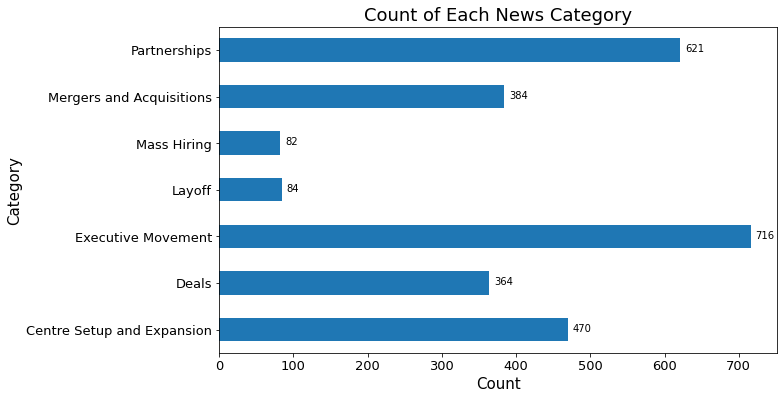

In [29]:
ax = final_df.groupby('category')['news_id'].count().plot(kind='barh', figsize=(10,6), fontsize=13)
ax.set_alpha(0.8)
ax.set_title("Count of Each News Category", fontsize=18)
ax.set_ylabel("Category", fontsize=15)
ax.set_xlabel("Count", fontsize=15)
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.show()

### Wordcloud For Different Categories

#### Layoff

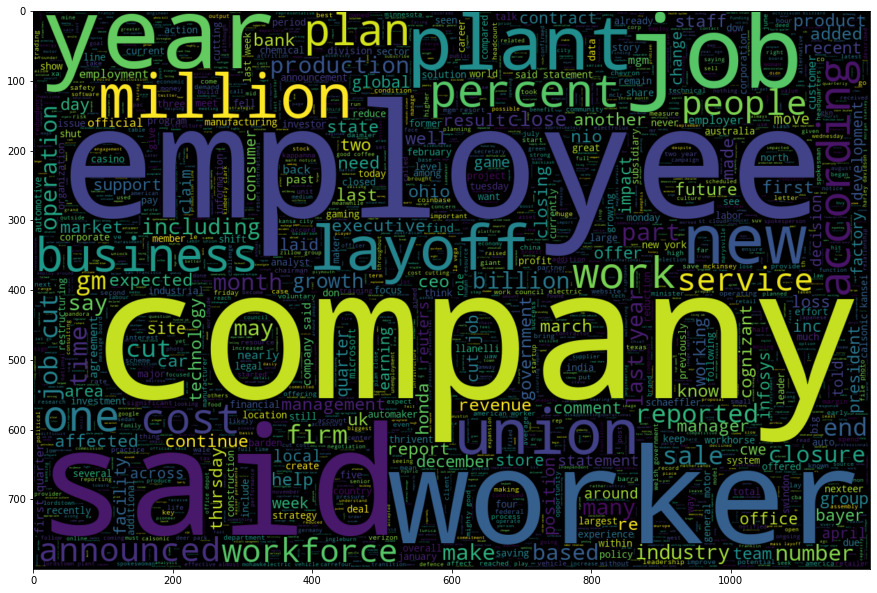

In [30]:
layoff = final_df[final_df.category=='Layoff']['text'].apply(lambda x:' '.join(x))
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(layoff))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

#### Mergers and Acquisitions

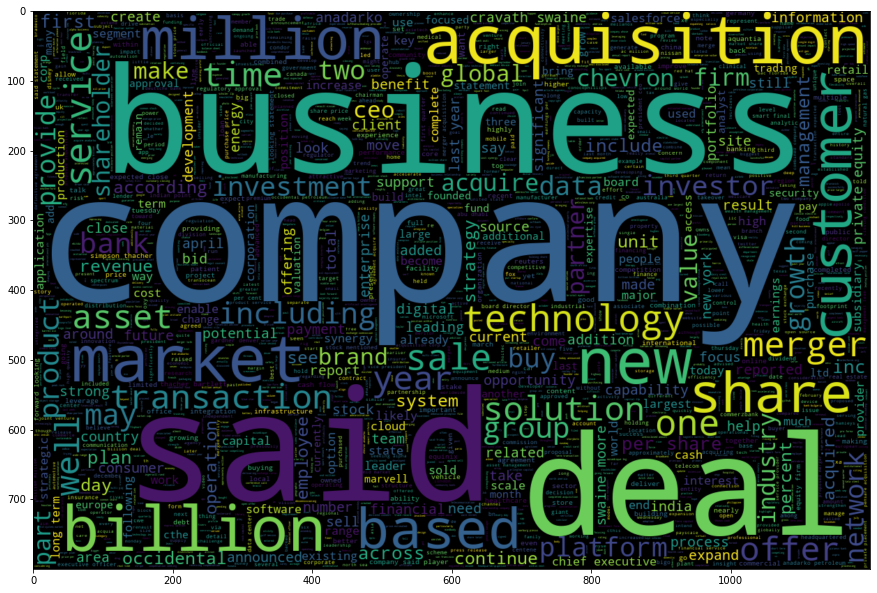

In [31]:
mergers_acquisitions = final_df[final_df.category=='Mergers and Acquisitions']['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(mergers_acquisitions))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

#### Mass Hiring

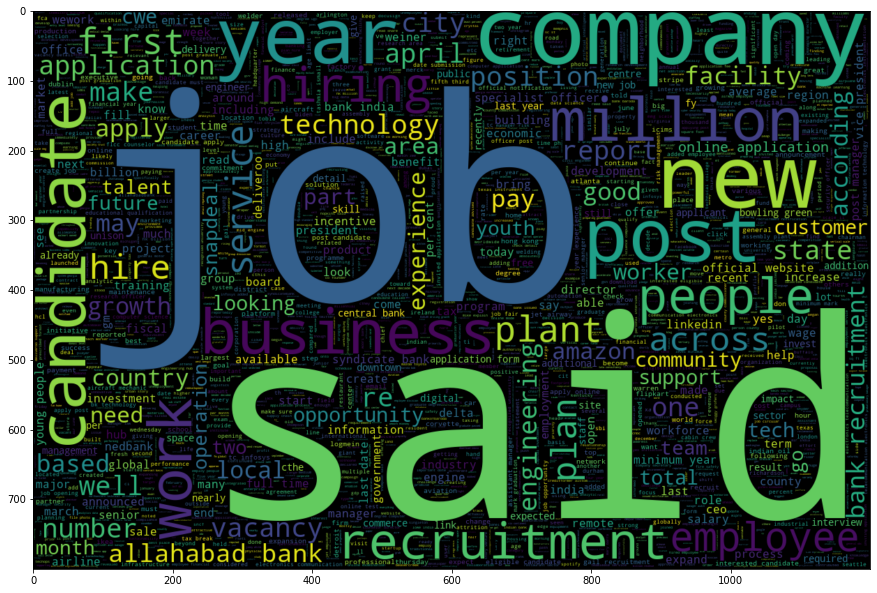

In [32]:
mass_hiring = final_df[final_df.category=='Mass Hiring']['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(mass_hiring))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

#### Executive Movement

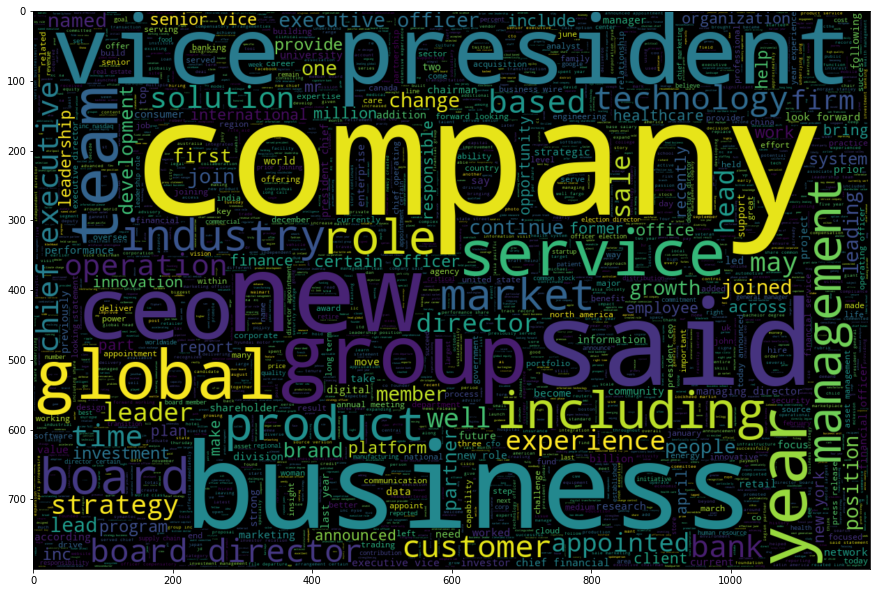

In [33]:
executive_movement = final_df[final_df.category=='Executive Movement']['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(executive_movement))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

#### Centre Setup and Expansion

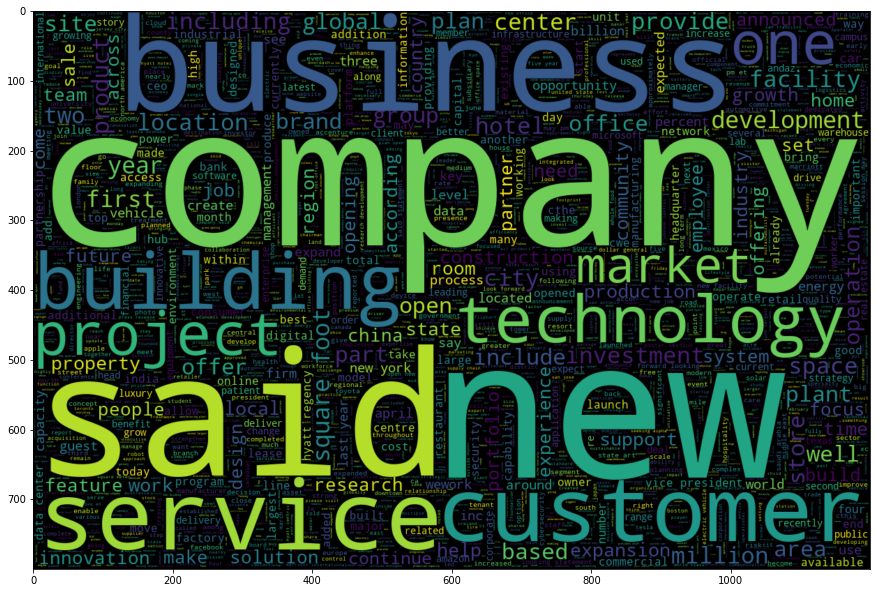

In [34]:
setup_expansion = final_df[final_df.category=='Centre Setup and Expansion']['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(setup_expansion))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

#### Deals

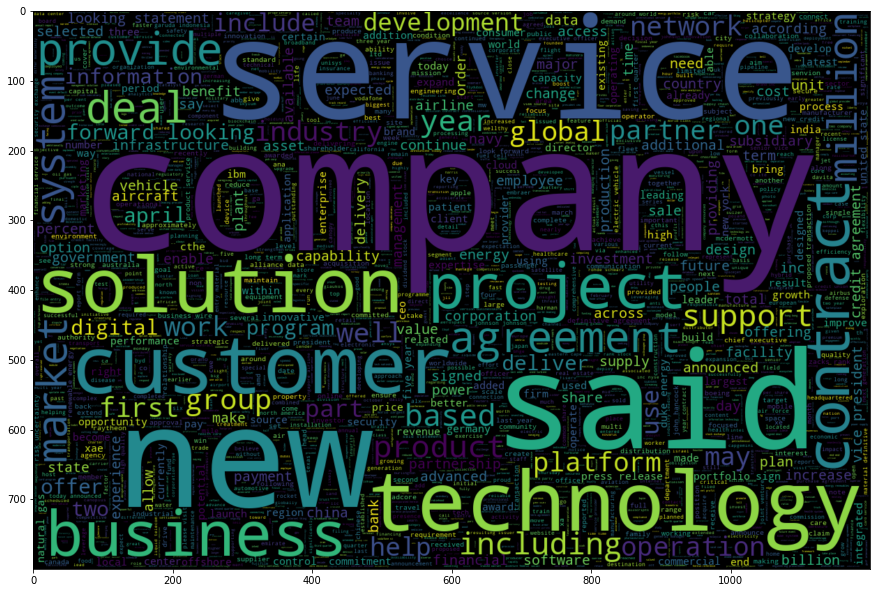

In [35]:
deals = final_df[final_df.category=='Deals']['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(deals))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

#### Partnerships

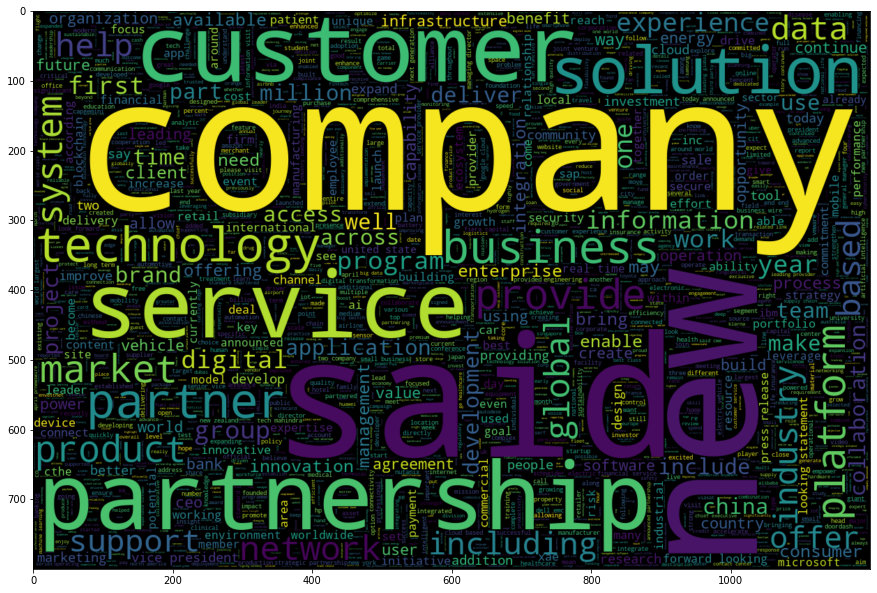

In [36]:
partnerships = final_df[final_df.category=='Partnerships']['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(partnerships))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

#### Number of characters in texts for each category

In [37]:
final_df['text_char_len'] = final_df['text'].apply(lambda x: len(' '.join(x)))

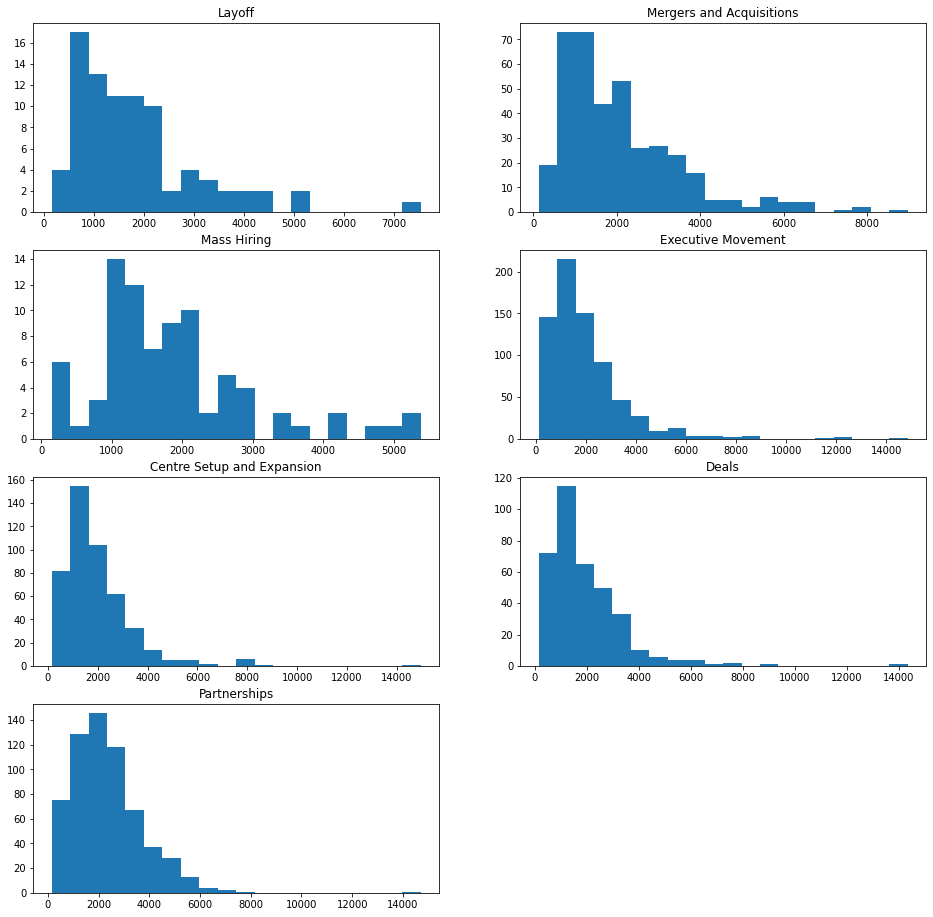

In [38]:
fig, ax=plt.subplots(4,2,figsize=(16,16))
count = 1
for i in ax:
    for j in i:
        if count==8:
            j.axis('off')
            break
        text_len=final_df[final_df['category_id']==count]['text_char_len'] 
        j.hist(text_len, bins=20)
        j.set_title(final_df[final_df['category_id']==count]['category'].values[0])
        count+=1

#### Number of words in texts for each category

In [39]:
final_df['text_word_len'] = final_df['text'].str.len() 

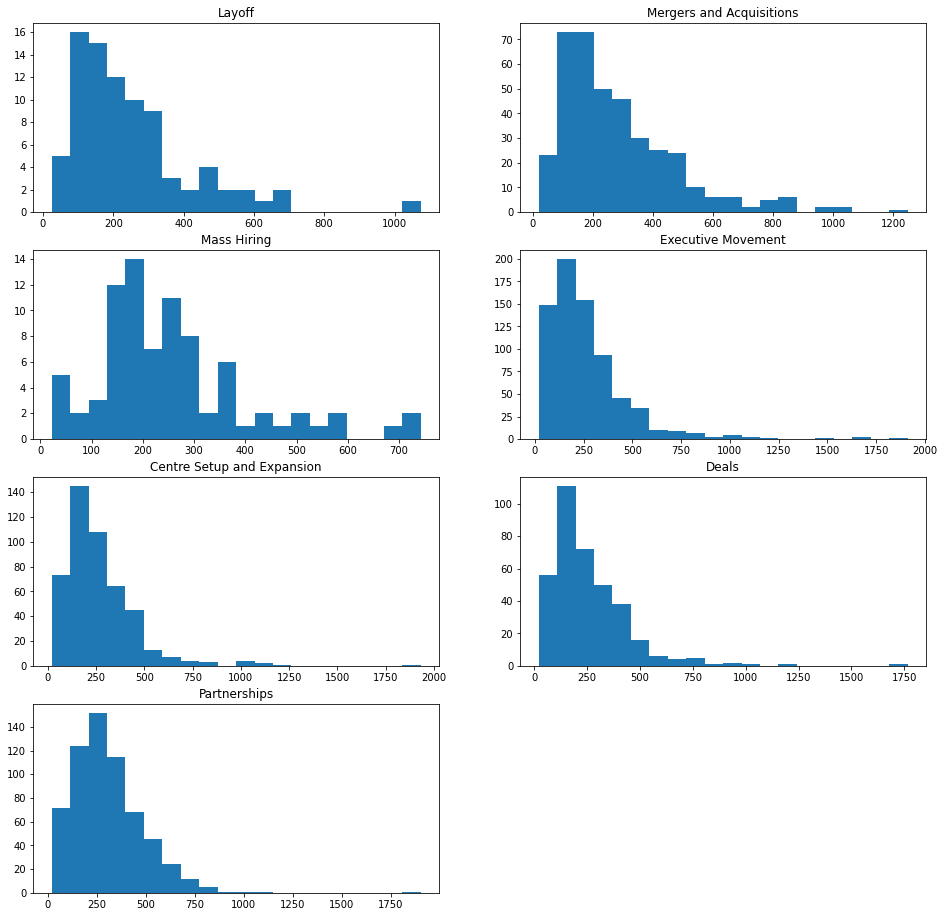

In [40]:
fig, ax=plt.subplots(4,2,figsize=(16,16))
count = 1
for i in ax:
    for j in i:
        if count==8:
            j.axis('off')
            break
        text_len=final_df[final_df['category_id']==count]['text_word_len'] 
        j.hist(text_len, bins=20)
        j.set_title(final_df[final_df['category_id']==count]['category'].values[0])
        count+=1

We can observe from the graphs that distribution of `Layoff` and `Mass Hiring` is same, `Center Setup and Expansion`, `Deals` and `Partnerships` are same, and `Mergers and Acquisitions` and `Executive Movement` are same.

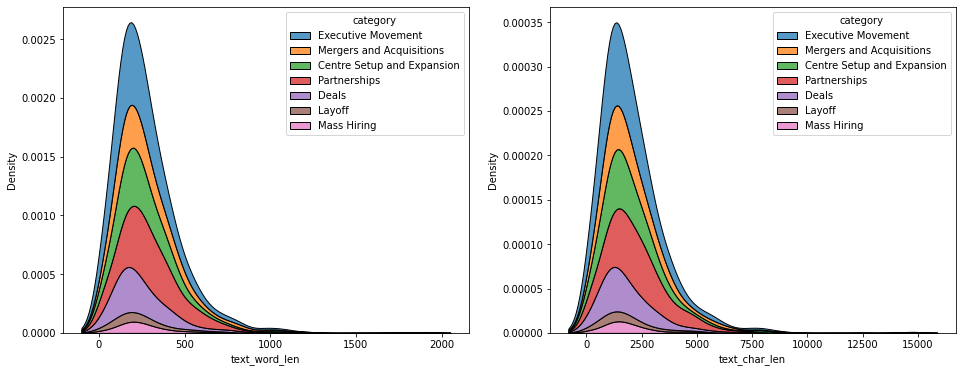

In [43]:
# KDE plot for words and characters length
fig, ax=plt.subplots(1,2,figsize=(16,6))
sns.kdeplot(data=final_df, x='text_word_len', hue='category', ax=ax[0], multiple='stack')
sns.kdeplot(data=final_df, x='text_char_len', hue='category', ax=ax[1], multiple='stack')
plt.show()

#### Average word length in a text for each category

In [44]:
final_df['text_avg_word_len'] = final_df['text'].apply(lambda x : np.mean([len(i) for i in x]))

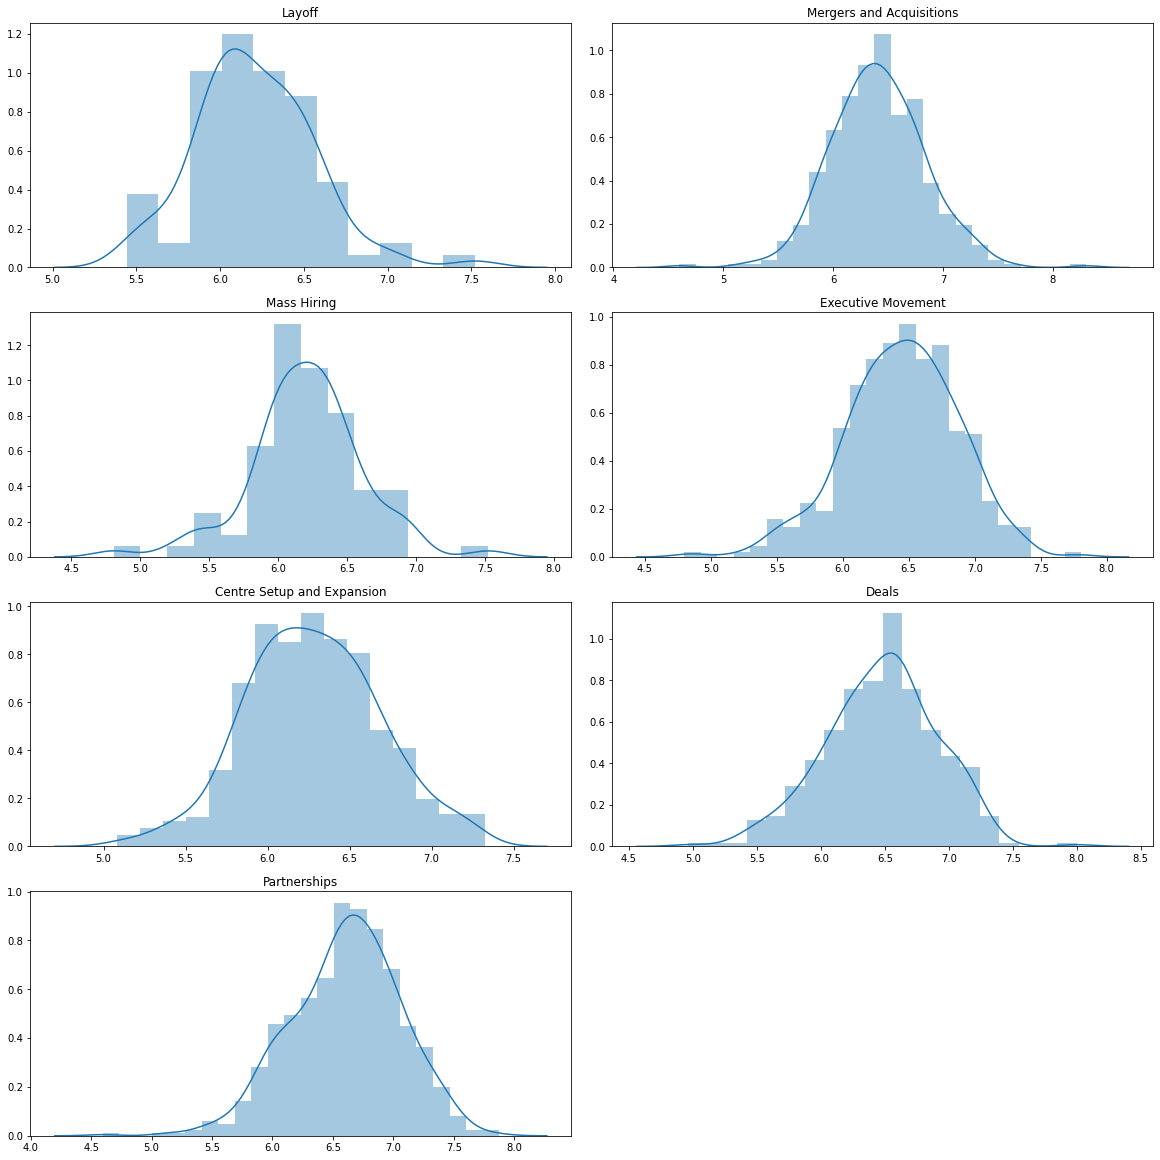

In [45]:
fig, ax=plt.subplots(4,2,figsize=(16,16), constrained_layout=True)
count = 1
for i in ax:
    for j in i:
        if count==8:
            j.axis('off')
            break
        word=final_df[final_df['category_id']==count]['text_avg_word_len']
        sns.distplot(word, ax=j)
        j.set_title(final_df[final_df['category_id']==count]['category'].values[0])
        count+=1
        j.set_xlabel('')

#### Creating Corpus of Words in Text

In [46]:
# Word Corpus
def get_corpus(text):
    words = []
    for i in text:
        for j in i:
            words.append(j.strip())
    return words
corpus = get_corpus(final_df.text)
corpus[:5]

['bank', 'baroda', 'hire', 'consultancy', 'firm']

In [47]:
# Most common words
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'company': 7208,
 'said': 4920,
 'new': 4741,
 'business': 4014,
 'year': 3956,
 'service': 3623,
 'the': 3335,
 'technology': 2999,
 'customer': 2823,
 'also': 2498}

In [48]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#### Unigram Analysis

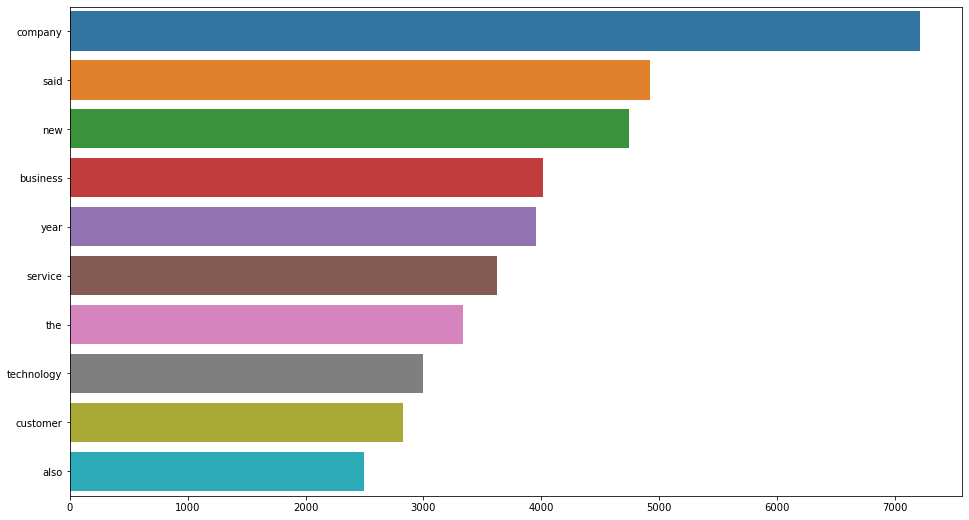

In [49]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(final_df.text.apply(lambda x: ' '.join(x)),10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))
plt.show()

#### Bigram Analysis

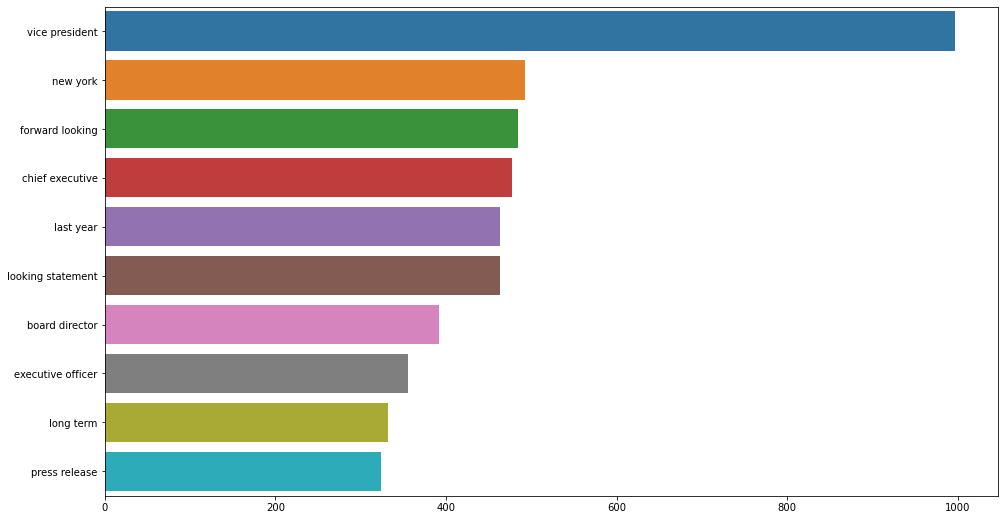

In [50]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(final_df.text.apply(lambda x: ' '.join(x)),10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

#### Trigram Analysis

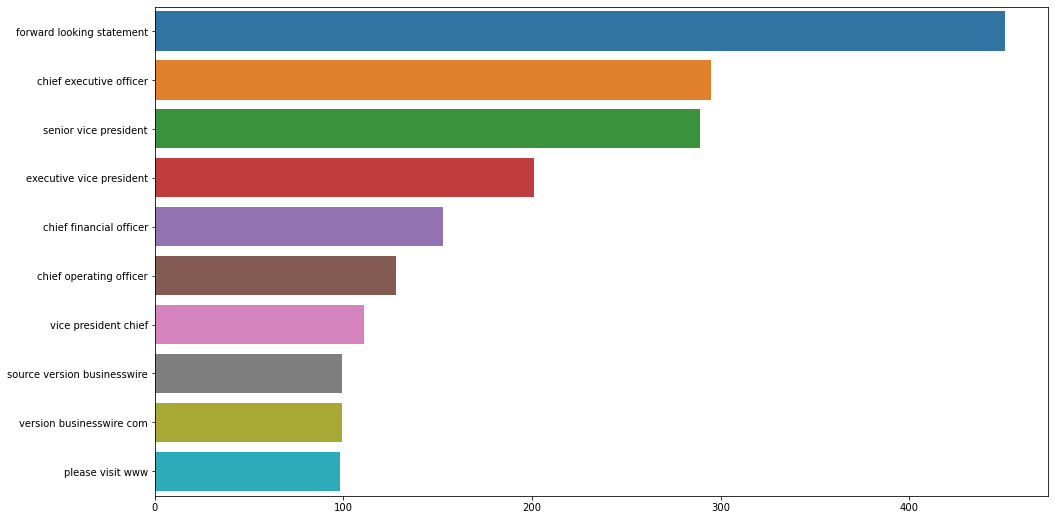

In [51]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(final_df.text.apply(lambda x: ' '.join(x)),10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))
plt.show()

#### Train-Test Split

In [52]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
final_df['categoryEncoded'] = encoder.fit_transform(final_df['category'])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(final_df['text'], final_df['categoryEncoded'], random_state = 43, test_size = 0.2)

In [54]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_mask=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [55]:
# Tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.apply(lambda x: ' '.join(x)).astype('str'), tokenizer, maxlen=256)
Xtest_encoded = regular_encode(X_test.apply(lambda x: ' '.join(x)).astype('str'), tokenizer, maxlen=256)
ytrain_encoded = to_categorical(y_train, dtype='int32')
ytest_encoded = to_categorical(y_test, dtype='int32')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### Model Building

#### Configuration for TPUs

The given news classifier is trained on using BERT model. Since, BERT is a very large model, it requires gpu's and tpu's to train quickly. Here, I have used TPU's provided by Kaggle to train this model.

In [56]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [57]:
train_x=X_train.apply(lambda x: ''.join(i+' ' for i in x))
test_x=X_test.apply(lambda x: ''.join(i+' '  for i in x))

## Feature Extraction
 
 Features are extracted from the dataset and TF-IDF(Term Frequency - Inverse Document Frequency) is used for this purpose.

In [58]:
tfidf=TfidfVectorizer(max_features=10000,min_df=6)
train_1=tfidf.fit_transform(train_x)
test_1=tfidf.transform(test_x)
print("No. of features extracted:", len(tfidf.get_feature_names()))
print(tfidf.get_feature_names()[:20])

train_arr=train_1.toarray()
test_arr=test_1.toarray()

No. of features extracted: 6494
['aa', 'ab', 'abatement', 'abb', 'abbott', 'abc', 'abercrombie', 'ability', 'able', 'abn', 'about', 'above', 'abroad', 'absolute', 'absolutely', 'absorb', 'abu', 'ac', 'academic', 'academy']


**Function for evaluation of model**

This function finds the Precison, Recall, F1-score and Accuracy of the trained model

In [60]:
def eval_model(y,y_pred):
    print("Recall score of the model:", round(recall_score(y_test, pred, average='weighted'), 3))
    print("Precision score of the model:", round(precision_score(y_test, pred, average='weighted'), 3))
    print("F1 score of the model:", round(f1_score(y,y_pred,average='micro'), 3))
    print("Accuracy of the model:", round(accuracy_score(y,y_pred),3))
    print("Accuracy of the model in percentage:", round(accuracy_score(y,y_pred)*100,3),"%")

**Function for Displaying the Confusion Matrix**

This function displays the confusion matrix of the model

In [61]:
def confusion_mat(color):
    cof=confusion_matrix(y_test, pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,8)], columns=[i for i in range(1,8)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8))
    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=list(encoder.classes_),yticklabels=list(encoder.classes_))
    plt.xlabel("Predicted Classes")
    plt.ylabel("Actual Classes")  

# Training of Model

### Model 1- Multinomial Naive Bayes

In [59]:
NB_MN=MultinomialNB()
NB_MN.fit(train_arr,y_train)
pred=NB_MN.predict(test_arr)

print("first 20 actual labels")
print(y_test.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

first 20 actual labels
[6, 1, 3, 5, 6, 5, 5, 6, 5, 1, 5, 0, 5, 0, 2, 6, 1, 1, 6, 2]
first 20 predicted labels
[6, 1, 2, 6, 6, 6, 2, 2, 0, 1, 5, 0, 2, 0, 2, 6, 6, 6, 0, 2]


### Evaluation of Results

In [62]:
eval_model(y_test,pred)   
a=round(accuracy_score(y_test,pred)*100,3)

Recall score of the model: 0.679
Precision score of the model: 0.686
F1 score of the model: 0.679
Accuracy of the model: 0.679
Accuracy of the model in percentage: 67.89 %


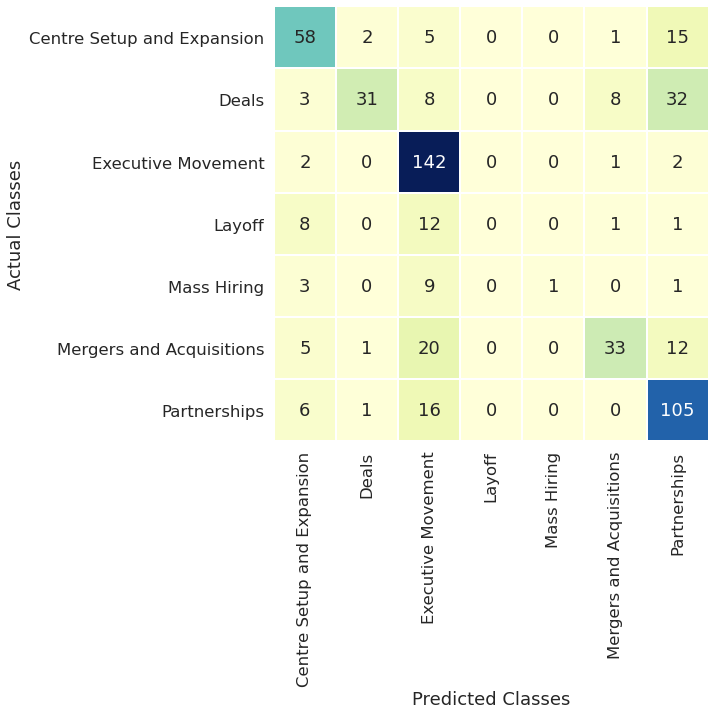

In [63]:
confusion_mat('YlGnBu')

### Model 2 - Decision Tree Classifier

In [64]:
DT=DecisionTreeClassifier()
DT.fit(train_arr,y_train)
pred=DT.predict(test_arr)

print("first 20 actual labels")
print(y_test.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

first 20 actual labels
[6, 1, 3, 5, 6, 5, 5, 6, 5, 1, 5, 0, 5, 0, 2, 6, 1, 1, 6, 2]
first 20 predicted labels
[6, 0, 2, 5, 6, 6, 5, 6, 5, 1, 5, 5, 5, 1, 2, 6, 1, 6, 6, 2]


### Evaluation of Results

In [65]:
eval_model(y_test,pred)
b=round(accuracy_score(y_test,pred)*100,3)

Recall score of the model: 0.65
Precision score of the model: 0.652
F1 score of the model: 0.65
Accuracy of the model: 0.65
Accuracy of the model in percentage: 64.954 %


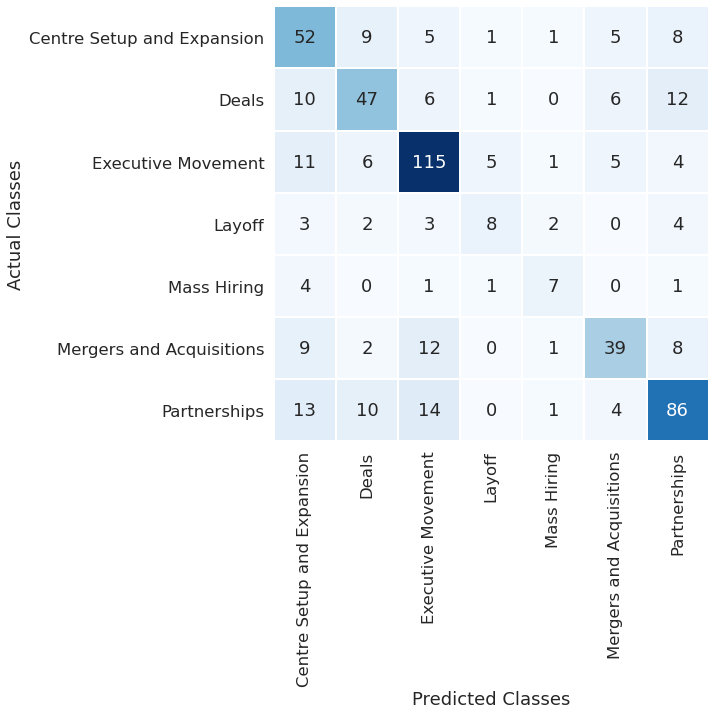

In [66]:
confusion_mat('Blues')

### Model 3 - Gaussian Naive Bayes

In [67]:
NB=GaussianNB()
NB.fit(train_arr,y_train)
pred=NB.predict(test_arr)

### Evaluation of Results

In [68]:
eval_model(y_test,pred)    
c=round(accuracy_score(y_test,pred)*100,3)

Recall score of the model: 0.508
Precision score of the model: 0.494
F1 score of the model: 0.508
Accuracy of the model: 0.508
Accuracy of the model in percentage: 50.826 %


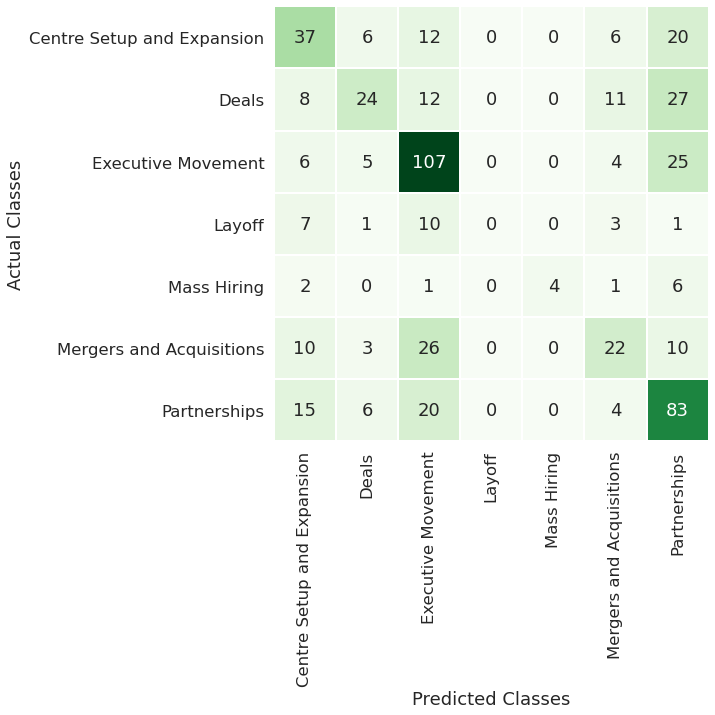

In [69]:
confusion_mat('Greens')

### Model 4 - Stochastic Gradient Descent Classifier

In [70]:
SGD=SGDClassifier()
SGD.fit(train_arr,y_train)
pred=SGD.predict(test_arr)

### Evaluation of Model

In [71]:
eval_model(y_test,pred)    
d=round(accuracy_score(y_test,pred)*100,3)

Recall score of the model: 0.826
Precision score of the model: 0.827
F1 score of the model: 0.826
Accuracy of the model: 0.826
Accuracy of the model in percentage: 82.569 %


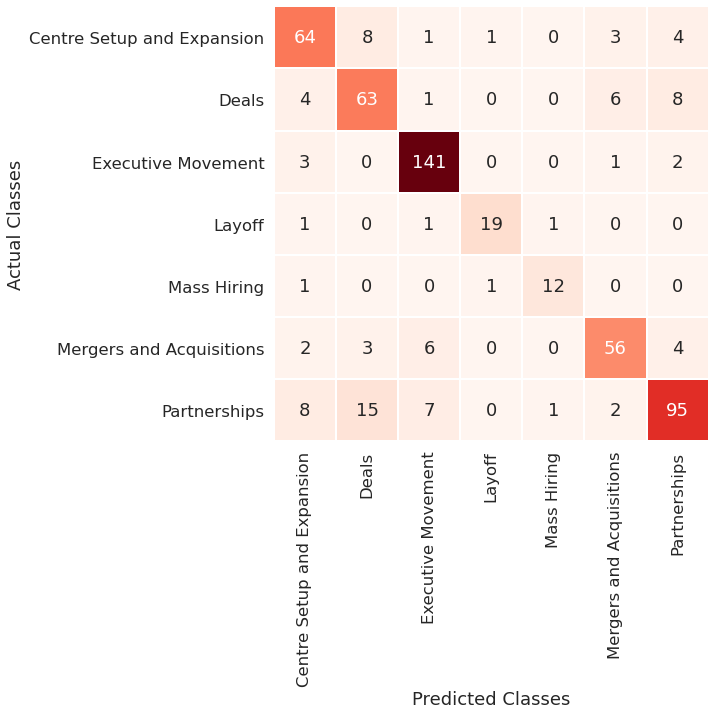

In [72]:
confusion_mat('Reds')

### Model 5 - Light Gradient Boosting Classifier

In [73]:
lgbm=LGBMClassifier()
lgbm.fit(train_arr,y_train)
pred=lgbm.predict(test_arr)

### Evaluation of Model

In [74]:
eval_model(y_test,pred)
e=round(accuracy_score(y_test,pred)*100,3)

Recall score of the model: 0.842
Precision score of the model: 0.843
F1 score of the model: 0.842
Accuracy of the model: 0.842
Accuracy of the model in percentage: 84.22 %


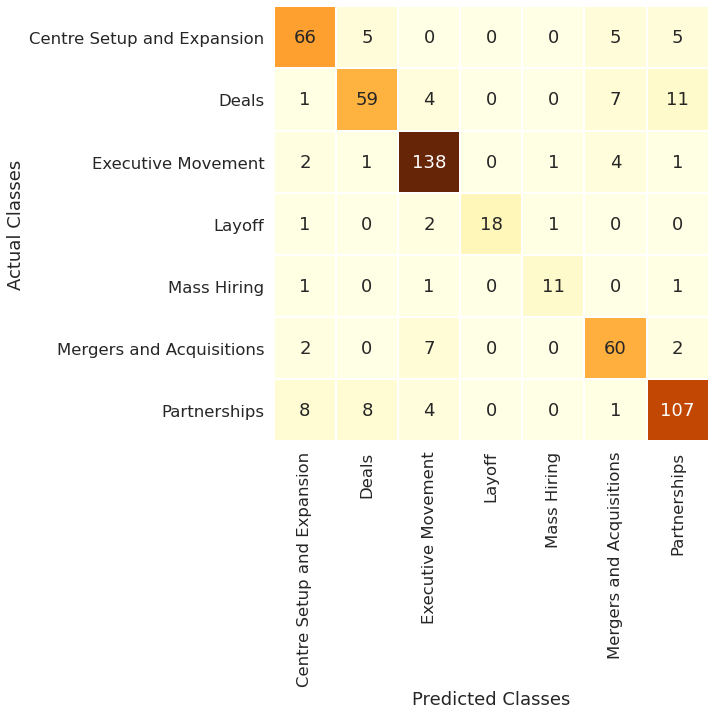

In [75]:
confusion_mat('YlOrBr')

### Model 6 - BERT

In [76]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 7 neurons as the number of unique categories is 7. 
    out = tf.keras.layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [77]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=256)
model.summary()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 256, 1024), (None 335141888 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 7175      
Total params: 335,149,063
Trainable params: 335,149,063
Non-trainable params: 0
_________________________________________________________________


#### Training Model

In [78]:
#creating the training and testing dataset.
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (tf.data.Dataset.from_tensor_slices((Xtrain_encoded, ytrain_encoded)).repeat().shuffle(2048).batch(BATCH_SIZE)
                 .prefetch(AUTO))
test_dataset = (tf.data.Dataset.from_tensor_slices(Xtest_encoded).batch(BATCH_SIZE))

In [79]:
#training for 10 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(train_dataset, steps_per_epoch=n_steps, epochs=10)

Epoch 1/10
8/8 [==============================] - 6s 736ms/step - accuracy: 0.3062 - loss: 1.8077
Epoch 2/10
8/8 [==============================] - 6s 739ms/step - accuracy: 0.5518 - loss: 1.3017
Epoch 3/10
8/8 [==============================] - 6s 737ms/step - accuracy: 0.7197 - loss: 0.8530
Epoch 4/10
8/8 [==============================] - 6s 739ms/step - accuracy: 0.8306 - loss: 0.5208
Epoch 5/10
8/8 [==============================] - 6s 739ms/step - accuracy: 0.8887 - loss: 0.3404
Epoch 6/10
8/8 [==============================] - 6s 737ms/step - accuracy: 0.9268 - loss: 0.2507
Epoch 7/10
8/8 [==============================] - 6s 739ms/step - accuracy: 0.9512 - loss: 0.1663
Epoch 8/10
8/8 [==============================] - 6s 736ms/step - accuracy: 0.9580 - loss: 0.1168
Epoch 9/10
8/8 [==============================] - 6s 737ms/step - accuracy: 0.9795 - loss: 0.0724
Epoch 10/10
8/8 [==============================] - 6s 738ms/step - accuracy: 0.9756 - loss: 0.0745


#### Evaluation

In [80]:
#making predictions
preds = model.predict(test_dataset,verbose = 1)
#converting the one hot vector output to a linear numpy array.
pred = np.argmax(preds, axis = 1)

3/3 [==============================] - 10s 3s/step


In [81]:
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred]
true_category = [encoded_classes[x] for x in y_test]

In [82]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

description  \
571   [future, energy, solution, land, multi, year, ...   
677   [qatargas, basf, sign, gas, treating, technolo...   
992   [company, make, scotch, tape, cutting, job, ne...   
1692  [activecampaign, announces, cx, automation, ac...   
497   [orange, marketing, becomes, hubspot, platinum...   

                 true_category        predicted_category  
571               Partnerships              Partnerships  
677                      Deals                     Deals  
992                     Layoff                    Layoff  
1692  Mergers and Acquisitions  Mergers and Acquisitions  
497               Partnerships              Partnerships

In [83]:
eval_model(y_test,pred)

f=round(accuracy_score(y_test,pred)*100,3)

Recall score of the model: 0.936
Precision score of the model: 0.937
F1 score of the model: 0.936
Accuracy of the model: 0.936
Accuracy of the model in percentage: 93.578 %


#### Confusion Matrix

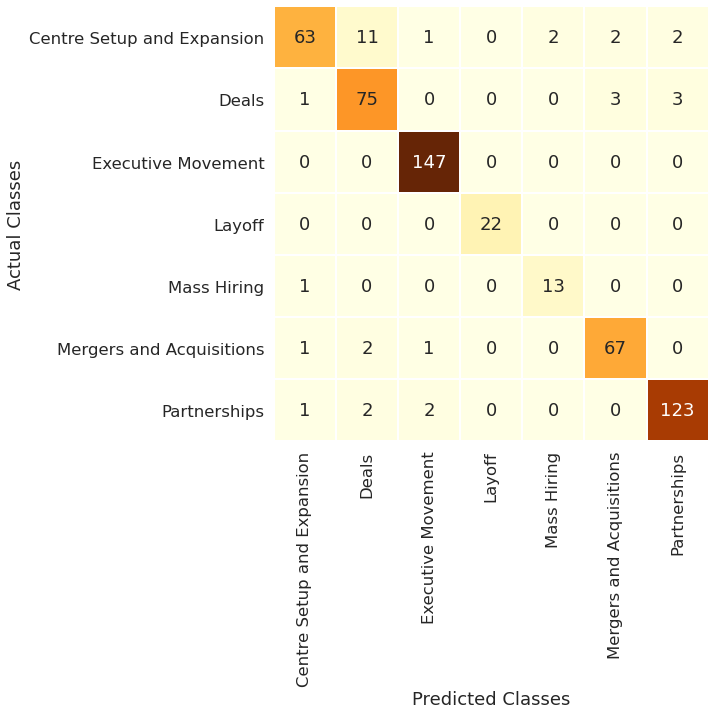

In [84]:
confusion_mat('YlOrBr')

## Comparison of Accuracies of Different Models

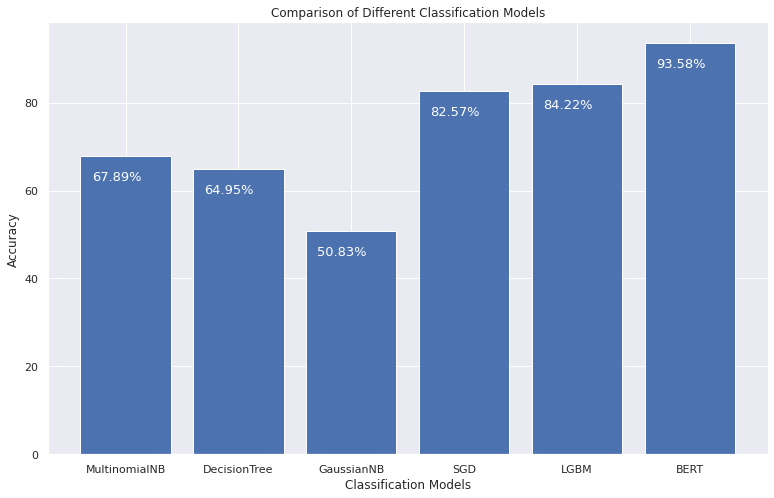

In [85]:
sns.set()
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
Models = ['MultinomialNB', 'DecisionTree', 'GaussianNB', 'SGD','LGBM', 'BERT']
Accuracy=[a,b,c,d,e,f]
ax.bar(Models,Accuracy);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-5.5, str(round(i.get_height(),2))+'%', fontsize=13, color='white')
plt.title('Comparison of Different Classification Models');
plt.ylabel('Accuracy');
plt.xlabel('Classification Models');

plt.show();

We can observe, BERT classifier gives the highest accuracy of `93.5%` and F1 score is also above `0.9` on test data followed by LGBM with `84.2%` accuracy and SGD with `82.57%` accuracy.

`Note`: Things we can do more to improvise the work or to be assured about the best model:

- Experimented with different embeddings(`TF-IDF` or `BERT Embeddings` or `Glove Embeddings`) and different models(SVM, CatBoost, LSTM with Attention, Bidirectional GRU) combinations
- Parameter Tuning: 
    - Grid Search for TF-IDF Parameters
    - Feature weights
- Evaluate on different combination of metrics (weighted/micro)
- Use of [mlflow and papermill](https://github.com/shadab-entrepreneur/Tech-Talks/tree/master/Experiment-with-Jupyter-Papermill-and-MLFlow) to do multiple experiments and track all of them from one UI
- Building pipeline and code scheduling if planning for putting the code in production